# Analyze industrial sensor data - Solution

This notebook holds the solution to the Industrial Data Analysis lab exercise in the PyR training. 

## To the instructor:
It is recommended to let the students work on one stage of the analysis flow at a time. Then, then present the solution of that stage to the class so that every student has a chance to catch up to continue with the next stage.

## Steps
The notebook passes through the following steps in reaching the ultimate end-goal: building an Python model that can be used to detect anomalies in one of the sensors: `Wheel Front Temp Celsius`

[Stage 1 - Read the input files and review data](#read_input)<br>
[Stage 2 - Transform and collect statistics](#transform_collect_statistics)<br>
[Stage 3 - Visualize the data](#visualize)<br>
[Stage 4 - Find correlations in the data](#find_correlations)<br>
[Stage 5 - Train model](#train_model)<br>

## Import required packages
Even though you can import new packages anywhwere in the notebook, it is common practice move the imports to the beginning of the notebook. This to immediately show the dependencies when someone else opens it.

Additionally, when you finished working on the notebook:
* Restart the kernel (Kernel --> Restart)
* Re-run the notebook (Run --> Run All Cells)

This is to ensure the notebook will also run if cells are not executed in the exact same sequence when you developed it. Very often, the exploration and analysis of data is an iterative process and you may end up renaming variables, updating dataframe columns. By running the full notebook from start to end and validating the end result, you will avoid errors when you need to use it later.

In [1]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

<a id='read_input'></a>
## Read input files
In this example, the files are directly read from the GitHub repository into a Pandas dataframe. Even though you could upload the file to the notebook server (Watson Studio or other), you will find it as easy to load the data directory from the internet.

The following 3 files have been made available:
* readings: http://raw.githubusercontent.com/fketelaars/pyr-industrial/master/readings.csv
* sensors: http://raw.githubusercontent.com/fketelaars/pyr-industrial/master/sensor.csv
* devices: http://raw.githubusercontent.com/fketelaars/pyr-industrial/master/device.csv

In [2]:
readings_df=pd.read_csv('http://raw.githubusercontent.com/fketelaars/pyr-industrial/master/readings.csv')
sensors_df=pd.read_csv('http://raw.githubusercontent.com/fketelaars/pyr-industrial/master/sensor.csv')
devices_df=pd.read_csv('http://raw.githubusercontent.com/fketelaars/pyr-industrial/master/device.csv')

Now that the data has been loaded into the 3 Pandas dataframes, check that the number of records match the expectations.
* readings: ~326k entries
* sensors: 27 entries
* devices: 4 entries

In [3]:
print('Number of readings: {}'.format(len(readings_df)))
print('Number of sensors: {}'.format(len(sensors_df)))
print('Number of devices: {}'.format(len(devices_df)))

Number of readings: 326221
Number of sensors: 27
Number of devices: 4


## View the first few rows of every data set
Show the top 5 rows of every dataframe

In [4]:
readings_df.head()

,tsepoch,sensor_id,value
0,1483228800000,1,0.000000
1,1483228800000,2,0.000000
2,1483228800000,3,0.000000
3,1483228800000,4,1.046513
4,1483228800000,5,0.000000


In [5]:
sensors_df.head()

,sensor_id,description,low_value,high_value
0,1,Oil Pressure,0,1
1,2,Air Pressure,0,1
2,3,Oil Temperature Celsius,0,1
3,4,Ambient Temperature Celsius,0,1
4,5,Partial Oxygen Pressure,0,1


In [6]:
devices_df.head()

,device_id,device_type,device_name
0,0,ROV,Calibration
1,1,ROV,RX3194-1
2,2,ROV,RX6710-3
3,3,ROV,RX6199-9


<a id='transform_collect_statistics'></a>
## Convert epoch timestamp to datetime
Extend the "readings" dataframe with a timestamp column which represents the human readable date and time for the `tsepoch` column. If you haven't noticed yet, the `tsepoch` timestamp is expressed in milliseconds.

In [7]:
readings_df['ts']=pd.to_datetime(readings_df['tsepoch'],unit='ms')
readings_df.head()

,tsepoch,sensor_id,value,ts
0,1483228800000,1,0.000000,2017-01-01
1,1483228800000,2,0.000000,2017-01-01
2,1483228800000,3,0.000000,2017-01-01
3,1483228800000,4,1.046513,2017-01-01
4,1483228800000,5,0.000000,2017-01-01


### Determine time span of the readings
Now that you've loaded the data, find the following properties for the readings:
* The number of seconds that the readings span
* The lowest timestamp in human readable format
* The highest timestamp in human readable format

In [8]:
start_tsepoch=readings_df['tsepoch'].min()
end_tsepoch=readings_df['tsepoch'].max()
start_time=readings_df['ts'].min()
end_time=readings_df['ts'].max()
print('Sample data set spans readings from {} to {}'.format(start_time,end_time))
print('Number of seconds spanned by date set: {}'.format((end_tsepoch-start_tsepoch)/1000))

Sample data set spans readings from 2017-01-01 00:00:00 to 2017-01-01 00:14:24
Number of seconds spanned by date set: 864.0


### Determine number of readings for each sensor
Not every sensor has the same sample rate. Later you will have to resample the readings to ensure you have a value for every time interval. Find the number of readings for every sensor and display this in a chart.

**Tip**: When using `matplotlib`, don't forget to add an instruction to tell the notebook that charts should be shown in-line.

In [9]:
sensor_counts=readings_df.groupby('sensor_id').size()

In [10]:
%matplotlib inline

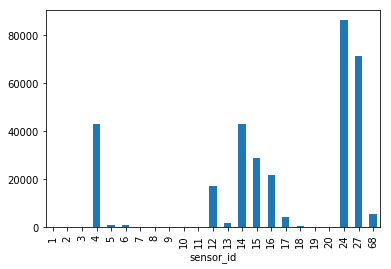

In [11]:
r=sensor_counts.plot(kind='bar')

### Determine statistics for each sensor and write to new "sensors" CSV file
The `sensor.csv` file contained placeholders for the count, minimum, maximum and mean of every sensor. Not all of these values were populated. You will need the sensor statistics later but you do not necessarily need to store them. If you run the notebook in the cloud, you can consider to try and persist the data in the object store, but retrieving the values in a dataframe is sufficient.

In [12]:
sensor_statsdf=readings_df.groupby('sensor_id', as_index=False, group_keys=False)['value'].agg(['count','min','max','mean']).reset_index()
sensor_statsdf

,sensor_id,count,min,max,mean
0,1,5,0.000000e+00,0.000000e+00,0.000000e+00
1,2,15,0.000000e+00,0.000000e+00,0.000000e+00
2,3,20,0.000000e+00,0.000000e+00,0.000000e+00
3,4,43200,6.483428e-01,1.354323e+00,9.992790e-01
4,5,864,0.000000e+00,0.000000e+00,0.000000e+00
5,6,864,0.000000e+00,0.000000e+00,0.000000e+00
6,7,87,0.000000e+00,0.000000e+00,0.000000e+00
7,8,124,0.000000e+00,0.000000e+00,0.000000e+00
8,9,15,0.000000e+00,0.000000e+00,0.000000e+00
9,10,44,0.000000e+00,0.000000e+00,0.000000e+00


Once you have retrieved the count, minimum, maximum and mean, join this data with the original sensors dataframe so that you can persist it as a csv file.

The resulting dataframe should have the following columns:
* sensor_id
* description
* low_value
* high_value
* mean_value

**Tip**: To be able to join, you may have to reset the index of the dataframe holding the aggregated values, or you may have to use the index of that dataframe to join with the sensors dataframe.

In [13]:
sensors_with_stats_df=sensors_df.merge(sensor_statsdf, left_on='sensor_id', right_on='sensor_id').drop(['low_value','high_value','count'], axis=1)
sensors_with_stats_df.columns=['sensor_id','description','low_value','high_value','mean_value']
sensors_with_stats_df.head()
# We cannot write back to the file system in Watson Studio
# sensors_with_stats_df.to_csv('sensors_with_stats.csv',index=False)

,sensor_id,description,low_value,high_value,mean_value
0,1,Oil Pressure,0.000000,0.000000,0.000000
1,2,Air Pressure,0.000000,0.000000,0.000000
2,3,Oil Temperature Celsius,0.000000,0.000000,0.000000
3,4,Ambient Temperature Celsius,0.648343,1.354323,0.999279
4,5,Partial Oxygen Pressure,0.000000,0.000000,0.000000


<a id='visualize'></a>
## Visualization

### Determine which sensors make sense to visualize
Sensors with a constant value can be ignored and should be dropped before visualizing. Use the sensor statistics you retrieved above to determine if sensors have a constant value. Drop the readings of those sensors.

**Tip**: When dropping rows or columns, you may get a warning that the original dataframe could be affected. Use the `copy()` function to make a copy of the original dataframe before deleting rows or columns.

In [14]:
non_zero_sensors_df=sensors_with_stats_df.loc[(sensors_with_stats_df['low_value']!=0) | \
                                           (sensors_with_stats_df['high_value']!=0)]
var_readings_df=readings_df.copy()[readings_df.sensor_id.isin(non_zero_sensors_df.sensor_id)]
var_readings_df.head()

,tsepoch,sensor_id,value,ts
3,1483228800000,4,1.046513e+00,2017-01-01
11,1483228800000,12,2.994643e+00,2017-01-01
13,1483228800000,14,2.434520e+02,2017-01-01
14,1483228800000,15,1.499227e+09,2017-01-01
15,1483228800000,16,1.782740e+02,2017-01-01


If your code is correct, approximately 321900 readings should remain in the new dataframe.

In [15]:
len(var_readings_df)

321911

## Plot some of the sensors
Pick a couple of sensor IDs (for example: 14, 27 and 68) and plot the values. Use the human readable timestamp for the x-axis.

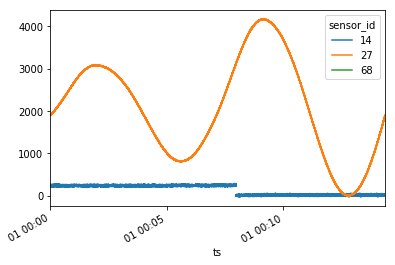

In [16]:
plot_readings_df=var_readings_df.copy()[var_readings_df.sensor_id.isin([14,27,68])]
plot_readings_df=plot_readings_df.pivot_table(index='ts',columns='sensor_id',values='value').reset_index()
plot_readings_df.plot(x='ts')

## Down-sample the different readings
Before we can start looking at correlations between different sensors, we need to match the timestamps of the readings from the different sensos. Let's try and down-sample the variable readings to create a pivoted dataframe with a value for every sensor and every timestamp.

To lose as little detail as possible, we will down-sample to 0.2 seconds. This means there will be 864 * 5 readings for every sensor.

**Tip**: Use the pandas `resample` function and `groupby` to down-sample the readings to 200 milliseconds.

In [17]:
readings_resample_df=var_readings_df.copy().set_index('ts').groupby('sensor_id')['value'].resample('200 ms').mean().reset_index()
readings_resample_df.head()

,sensor_id,ts,value
0,4,2017-01-01 00:00:00.000,1.022362
1,4,2017-01-01 00:00:00.200,0.983486
2,4,2017-01-01 00:00:00.400,0.942015
3,4,2017-01-01 00:00:00.600,0.990852
4,4,2017-01-01 00:00:00.800,1.016707


In [18]:
readings_resample_df.dropna(inplace=True)

Check that you more or less have the same number of samples for each sensor now.

In [19]:
readings_resample_df.groupby('sensor_id').size()

sensor_id
4     4320
12    4320
14    4320
15    4320
16    4320
17    4320
18     576
24    4320
27    4320
68    4321
dtype: int64

This is what we expected. We can now pivot the table to find correlations.

<a id='find_correlations'></a>
## Find correlations between sensors
Now that we have the equivalent number of readings for every sensor, you can find correlcations between the different sensor IDs. You will need to match up the readings for different sensors with each other.

**Tip**: Use the pandas `pivot_table` function to get 1 column for every sensor. Every row will have a timestamp and value for each of the sensors.

In [20]:
pivot_readings_df=readings_resample_df.pivot_table(index='ts',columns='sensor_id',values='value').reset_index()
pivot_readings_df.head()

sensor_id,ts,4,12,14,15,16,17,18,24,27,68
0,2017-01-01 00:00:00.000,1.022362,3.098834,236.673392,1.438383e+09,177.932999,0.988788,69.092725,-0.758444,1900.839515,105.162011
1,2017-01-01 00:00:00.200,0.983486,2.928565,237.061628,1.486344e+09,188.979559,0.960407,NaN,-0.771843,1903.098460,116.368830
2,2017-01-01 00:00:00.400,0.942015,2.966939,238.252973,1.497702e+09,197.380716,0.996847,NaN,-0.748893,1904.788180,126.253062
3,2017-01-01 00:00:00.600,0.990852,2.913246,228.425294,1.480138e+09,207.556741,0.979921,NaN,-0.787001,1906.934125,112.097543
4,2017-01-01 00:00:00.800,1.016707,2.903093,234.805413,1.481220e+09,216.353044,1.064194,NaN,-0.762562,1909.115977,123.677191


The column names now reference the `sensor_id` which really is not that meaningful. Before correlating, let's give the columns some meaningful names.

**Tip**: Join the numeric column names with the `sensors` data to retrieve the names. Once you have changed the column names, show the first 5 rows of the resulting dataframe.

In [21]:
sensor_cols=pd.DataFrame(pivot_readings_df.columns[1:])
sensor_cols=sensor_cols.astype('int64')

In [22]:
pivot_readings_df.columns=['timestamp'] + sensor_cols.merge(sensors_with_stats_df)['description'].tolist()
pivot_readings_df.head()

,timestamp,Ambient Temperature Celsius,Ambient Pressure mPa,Compressor Actual,Water Pump Pressure Pa,Turbine 1 RPM,Turbine 2 RPM,Torque Correction 1,Wheel 2 Speed RPM,Wheel Front Speed RPM,Wheel Front Temp Celsius
0,2017-01-01 00:00:00.000,1.022362,3.098834,236.673392,1.438383e+09,177.932999,0.988788,69.092725,-0.758444,1900.839515,105.162011
1,2017-01-01 00:00:00.200,0.983486,2.928565,237.061628,1.486344e+09,188.979559,0.960407,NaN,-0.771843,1903.098460,116.368830
2,2017-01-01 00:00:00.400,0.942015,2.966939,238.252973,1.497702e+09,197.380716,0.996847,NaN,-0.748893,1904.788180,126.253062
3,2017-01-01 00:00:00.600,0.990852,2.913246,228.425294,1.480138e+09,207.556741,0.979921,NaN,-0.787001,1906.934125,112.097543
4,2017-01-01 00:00:00.800,1.016707,2.903093,234.805413,1.481220e+09,216.353044,1.064194,NaN,-0.762562,1909.115977,123.677191


### Build the correlations table

In [23]:
readings_cov=pivot_readings_df.corr()
readings_cov

,Ambient Temperature Celsius,Ambient Pressure mPa,Compressor Actual,Water Pump Pressure Pa,Turbine 1 RPM,Turbine 2 RPM,Torque Correction 1,Wheel 2 Speed RPM,Wheel Front Speed RPM,Wheel Front Temp Celsius
Ambient Temperature Celsius,1.000000,0.018101,-0.013580,-0.000299,-0.021518,-0.005827,0.053252,0.002389,-0.029177,-0.025799
Ambient Pressure mPa,0.018101,1.000000,-0.006644,-0.033704,-0.012780,-0.039897,-0.058797,-0.012262,-0.021625,-0.019143
Compressor Actual,-0.013580,-0.006644,1.000000,-0.012677,-0.000430,0.002750,-0.318244,-0.198662,-0.028047,0.039330
Water Pump Pressure Pa,-0.000299,-0.033704,-0.012677,1.000000,-0.024797,0.005899,0.001223,0.018460,0.003635,0.002972
Turbine 1 RPM,-0.021518,-0.012780,-0.000430,-0.024797,1.000000,-0.002376,0.029571,-0.002757,-0.001488,-0.003213
Turbine 2 RPM,-0.005827,-0.039897,0.002750,0.005899,-0.002376,1.000000,0.090285,-0.002401,0.000941,0.003342
Torque Correction 1,0.053252,-0.058797,-0.318244,0.001223,0.029571,0.090285,1.000000,0.335373,0.399227,0.342273
Wheel 2 Speed RPM,0.002389,-0.012262,-0.198662,0.018460,-0.002757,-0.002401,0.335373,1.000000,0.188848,0.188577
Wheel Front Speed RPM,-0.029177,-0.021625,-0.028047,0.003635,-0.001488,0.000941,0.399227,0.188848,1.000000,0.959202
Wheel Front Temp Celsius,-0.025799,-0.019143,0.039330,0.002972,-0.003213,0.003342,0.342273,0.188577,0.959202,1.000000


### Show correlations in heatmap
The above correlation diagram is a little difficult to read. It is better to convert this into a heatmap.

**Tip**: The Seaborn package has some nice heatmaps that are easy to use. https://seaborn.pydata.org/

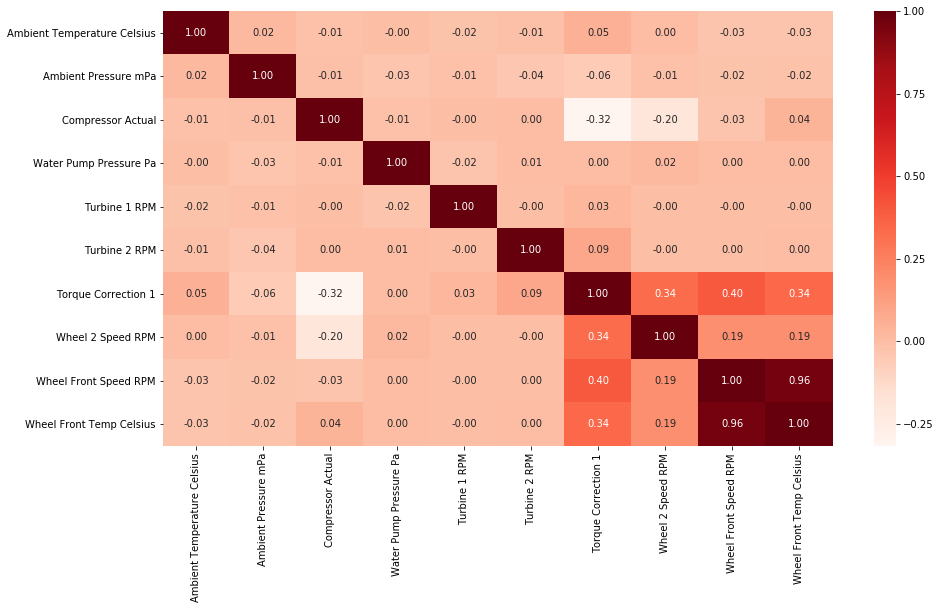

In [24]:
plt.figure(figsize=(15,8))
sns.heatmap(readings_cov, annot=True, fmt='.2f',cmap='Reds')
plt.show()

From the above it is obvious that `Wheel Front Speed RPM` and `Wheel Front Temp Celsius` are strongly correlated, let's plot this in a regression plot.

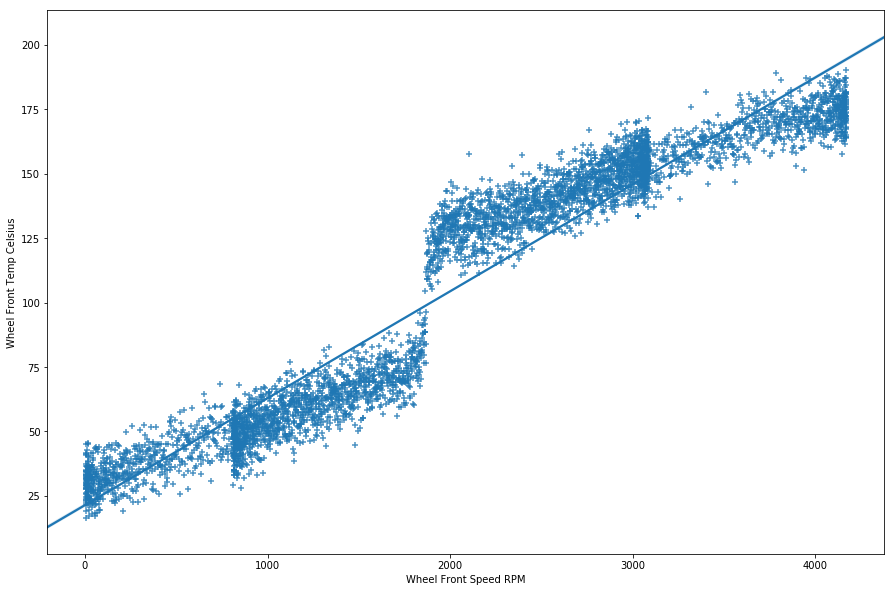

In [25]:
plt.figure(figsize=(15,10))
sns.regplot(pivot_readings_df['Wheel Front Speed RPM'], pivot_readings_df['Wheel Front Temp Celsius'],marker='+')
plt.show()

The covariance between the speed and temperature is clearly visible in the chart above.

<a id='train_model'></a>
## Train model on the data

Now that we have found a correlation, let's try to build a model we can use for predictions.

### Import additional packages
You can choose to import additional packages here, but in the end it is recommended to move all imports to the top of the notebook.

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

### Split the data in a training and test set
It is best to start from the pivoted dataframe. If you didn't do so before, you first have remove any NaN values from the overall pivoted dataframe, otherwise the training or testing of the model will fail.

In [27]:
speed_temp_df=pivot_readings_df[['timestamp','Wheel Front Speed RPM','Wheel Front Temp Celsius']].dropna()

Now split the dataframe into a training and test set. Please note that the independent variables (features) and dependent variables (labels) must end up in different dataframes/series.

**Tip**: SciKit Learn has a nice function that will split up a dataframe in training and testing data, and also separate features from labels.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(speed_temp_df['Wheel Front Speed RPM'], speed_temp_df['Wheel Front Temp Celsius'],\
                                                   test_size=0.2)

X_train = X_train.values.reshape(-1,1)
X_test = X_test.values.reshape(-1,1)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (3456, 1)
X_test shape:  (864, 1)
y_train shape:  (3456, 1)
y_test shape:  (864, 1)


### First try simple linear model

Try to fit a simple linear regression model against the data. When the model has been fit, calculate the R<sup>2</sup> score.

**Tip**: When you try this for the first time, SciKit Learn may throw errors because the shape of the training and test data is not what it expects. With Pandas you can re-shape the data to the desired format using the `reshape()` function.

Fit the linear model.

In [29]:
lm=LinearRegression()
simple_lm=lm.fit(X_train, y_train)

Calculate the R<sup>2</sup> score.

In [30]:
print('Simple linear model R-square score: {}'.format(simple_lm.score(X_test,y_test)))

Simple linear model R-square score: 0.9203755032474091


### Try to improve the score with a polynomial regression
To use a polynomial regression, it is best to create a pipeline that will first generate the polynomial features and then train.

You can choose to import additional packages here, but in the end it is recommended to move all imports to the top of the notebook.

In [31]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline

In [32]:
# Define the pipeline
poly_pipe=Pipeline([("polynomial_features",PolynomialFeatures(degree=3)),("linear_regression",LinearRegression())])
pm=poly_pipe.fit(X_train, y_train)

Define the pipeline and fit the model. When the model has been trained, calculate the R<sup>2</sup> score and see if it has improved compared to the simple linear model. Based on the degree of polynomial features the score will improve or not. With the provided data set, a degree of 3 was optimal.

In [33]:
print('Polynomial model R-square score: {}'.format(pm.score(X_test,y_test)))

Polynomial model R-square score: 0.954311996108386


### Now plot everything in 1 diagram
You should now have 2 models. It would be good to visualize how well the models can predict the value of temperature given the speed.

First assemble a dataframe that will have the following columns:
* speed
* actual temperature
* predicted temperature for the simple linear regression
* predicted temparature for the polynomial regression

In [34]:
speed_temp_plot_df=speed_temp_df.copy()
speed_temp_plot_df['predicted_linreg']=simple_lm.predict(speed_temp_plot_df['Wheel Front Speed RPM'].values.reshape(-1,1))
speed_temp_plot_df['predicted_poly']=pm.predict(speed_temp_plot_df['Wheel Front Speed RPM'].values.reshape(-1,1))
speed_temp_plot_df.head()

,timestamp,Wheel Front Speed RPM,Wheel Front Temp Celsius,predicted_linreg,predicted_poly
0,2017-01-01 00:00:00.000,1900.839515,105.162011,100.377477,101.197574
1,2017-01-01 00:00:00.200,1903.098460,116.368830,100.471349,101.325552
2,2017-01-01 00:00:00.400,1904.788180,126.253062,100.541567,101.421283
3,2017-01-01 00:00:00.600,1906.934125,112.097543,100.630744,101.542864
4,2017-01-01 00:00:00.800,1909.115977,123.677191,100.721412,101.666481


Once you have the dataframe with these columns, plot the values. Try to improve the visualization by:
* Choosing a figure size that will fit the width of your screen
* Choose different colours for the plotted points
* Create a legend that explains the values and colours shown in the chart

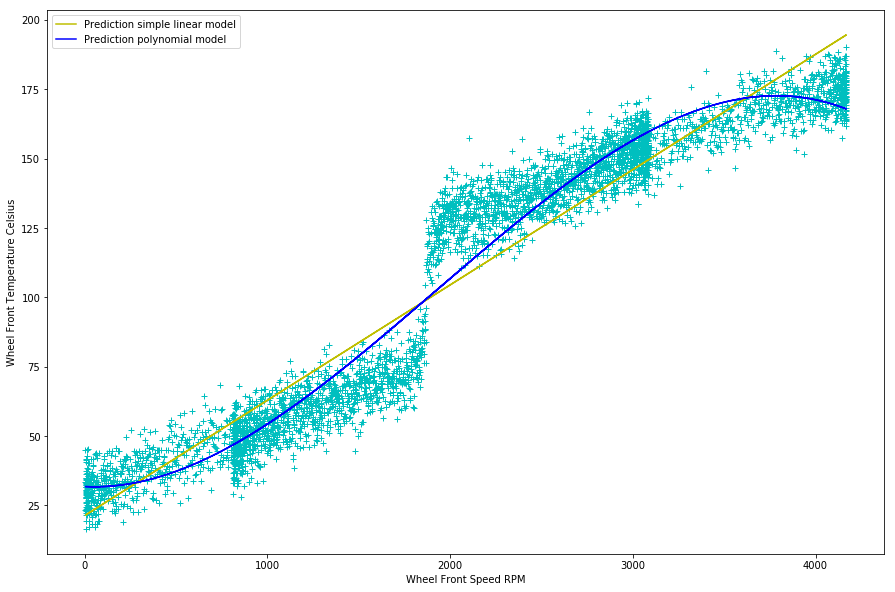

In [35]:
plt.figure(figsize=(15,10))
plt.plot(speed_temp_plot_df['Wheel Front Speed RPM'].values,speed_temp_plot_df['Wheel Front Temp Celsius'].values,'c+')
plt.plot(speed_temp_plot_df['Wheel Front Speed RPM'].values,speed_temp_plot_df['predicted_linreg'].values,'y', label='Prediction simple linear model')
plt.plot(speed_temp_plot_df['Wheel Front Speed RPM'].values,speed_temp_plot_df['predicted_poly'].values,'b', label='Prediction polynomial model')
plt.legend(loc='upper left')
plt.xlabel('Wheel Front Speed RPM')
plt.ylabel('Wheel Front Temperature Celsius')
plt.show()